### Package Used

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from  sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import shap
from sklearn.inspection import permutation_importance


### Import Data

In [297]:
Airbnb = pd.read_csv("../Data/EDA_data.csv")

### remove extreme outlier for better prediction
Airbnb = Airbnb[Airbnb["price"] < Airbnb["price"].describe()[6] + 
                3*(Airbnb["price"].describe()[6]-Airbnb["price"].describe()[4])]

### Spliting data into X and y
X = Airbnb.loc[:,Airbnb.columns!="price"]
y = Airbnb["price"]

## Spliting

In [298]:
# Split into train, validation, and test
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(28533, 11)
(9511, 11)
(9512, 11)


In [322]:
# ## Train
# y_train.plot.hist(log=True, bins = 100)
# #plt.semilogy()
# #plt.semilogx()
# plt.xlabel('Airbnb price $/night')
# plt.ylabel('Count')
# plt.title('Train set Price Distribution')
# plt.show()
# 
# ## Validation
# y_val.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(y_train)),50))
# plt.semilogy()
# plt.semilogx()
# plt.xlabel('Airbnb price $/night')
# plt.ylabel('Count')
# plt.title('Validation set Price Distribution')
# plt.show()
# 
# ## Test
# y_test.plot.hist(log=True, bins = np.logspace(np.log10(1),np.log10(np.max(y_train)),50))
# plt.semilogy()
# plt.semilogx()
# plt.xlabel('Airbnb price $/night')
# plt.ylabel('Count')
# plt.title('Test set Price Distribution')
# plt.show()

## Preprocessing

#### Check data type

In [299]:
#X.dtypes

#### Check Missing Data

In [300]:
print('fraction of missing values in features:')
print("\n")
perc_missing_per_ftr = X.isnull().sum(axis=0)/X.shape[0]
print(perc_missing_per_ftr[perc_missing_per_ftr>0])

fraction of missing values in features:


reviews_per_month                          0.200416
gap_between_last_review_and_end_of_2019    0.200416
dtype: float64


There are two features in the feature matric contain missing values and they are `reviews_per_month` and `gap_between_last_review_and_end_of_2019`. Their corresponding missing proportion are **20.56%**, and **20.56%**. All two features are **continuous** variable. In later analysis, we will use **reduced-features model** to deal with missingness.

#### Preprocess

In [301]:
ordinal_ftrs= ["room_type"]
ordinal_cats = [["Shared room", "Private room", "Entire home/apt"]]
onehot_ftrs = ["neighbourhood_group", "neighbourhood"]
minmax_ftrs = ["availability_365"]
std_ftrs = ["minimum_nights", "number_of_reviews", "longitude", "latitude", 
            "gap_between_last_review_and_end_of_2019","reviews_per_month", "calculated_host_listings_count"]
# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=df_val,columns = feature_names)
print(df_val.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(28533, 231)
(9511, 231)
(9512, 231)


#### Check strong correlated features

In [113]:
## Check any strong correlated features
corr = df_train.corr().round(2)
n = 0
for i in range(230):
    if sum(corr.iloc[i] < -0.8)>0:
        n+=1
        print(i)
    if sum(corr.iloc[i] >  0.8)>1:
        n+=1
        print(i)
print("Any absolute correlation score larger than 0.8: ",str(n))

Any absolute correlation score larger than 0.8:  0


### Modeling
#### Baseline Score (RMSE)

In [114]:
RMSE_base = []
for i in range(10):
    
    ## Data split
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42+i)
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42+i)
    
    ## Baseline prediction
    baseline_pred = [np.mean(y_train) for i in range(len(y_test))]
    
    ## Baseline RMSE
    RMSE_base.append(np.sqrt(mean_squared_error(y_test,baseline_pred)))

print("Baseline RMSE Mean: ",str(np.mean(RMSE_base)))
print("Baseline RMSE Std: ",str(np.std(RMSE_base)))

Baseline RMSE Mean:  83.13082284908617
Baseline RMSE Std:  0.887770569544191


#### Check Pattern

In [115]:
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)
print("\n\nUnique Patterns:")
mask = df_test[['std__gap_between_last_review_and_end_of_2019','std__reviews_per_month']].isnull()
unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

data dimensions: (28533, 231)
fraction of missing values in features:
std__gap_between_last_review_and_end_of_2019    0.198086
std__reviews_per_month                          0.198086
dtype: float64
fraction of points with missing values: 0.19808642624329723


Unique Patterns:
(2, 2)
[False False] 7557
[ True  True] 1955


#### ML Model

In [126]:
def Random_forest_model(param_grid, X_train, y_train, X_val, y_val, X_test, y_test):

    
    ## Initial list
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    ## CV
    for p in range(len(ParameterGrid(param_grid))):
        print("Cross Validation ...")
        params = ParameterGrid(param_grid)[p]
        clf = RandomForestRegressor(**params,random_state = 42*p,n_jobs=-1)
        
        # loop through all posible model
        clf.fit(X_train,y_train)
        models.append(clf) 
        
        # calculate train and validation accuracy scores
        ## Train
        y_train_pred = clf.predict(X_train)
        train_score[p] = np.sqrt(mean_squared_error(y_train,y_train_pred))
        ## Validation
        y_val_pred = clf.predict(X_val)
        val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    #print("--------------------------------------------------------")    
    #print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    
    ## Model with best validation
    final_model = models[np.argmin(val_score)]
    
    ## Test
    y_test_pred = final_model.predict(X_test)
    
    # Output test prediction
    return(y_test_pred, final_model)

def Ridge_model(param_grid, X_train, y_train, X_val, y_val, X_test, y_test):

    
    ## Initial list
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    ## CV
    for p in range(len(ParameterGrid(param_grid))):
        print("Cross Validation ...")
        params = ParameterGrid(param_grid)[p]
        clf = Ridge(**params, random_state = 42*p, max_iter=100000000)
        
        # loop through all posible model
        clf.fit(X_train,y_train)
        models.append(clf) 
        
        # calculate train and validation accuracy scores
        ## Train
        y_train_pred = clf.predict(X_train)
        train_score[p] = np.sqrt(mean_squared_error(y_train,y_train_pred))
        ## Validation
        y_val_pred = clf.predict(X_val)
        val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    #print("--------------------------------------------------------")    
    #print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    
    ## Model with best validation
    final_model = models[np.argmin(val_score)]
    
    ## Test
    y_test_pred = final_model.predict(X_test)
    
    # Output test prediction
    return(y_test_pred, final_model)

def SVR_model(param_grid, X_train, y_train, X_val, y_val, X_test, y_test):

    
    ## Initial list
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    ## CV
    for p in range(len(ParameterGrid(param_grid))):
        print("Cross Validation ...")
        params = ParameterGrid(param_grid)[p]
        clf = SVR(**params)
        
        # loop through all posible model
        clf.fit(X_train,y_train)
        models.append(clf)
        # calculate train and validation accuracy scores
        ## Train
        y_train_pred = clf.predict(X_train)
        train_score[p] = np.sqrt(mean_squared_error(y_train,y_train_pred))
        ## Validation
        y_val_pred = clf.predict(X_val)
        val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))
    
    #print("--------------------------------------------------------")    
    #print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    
    ## Model with best validation
    final_model = models[np.argmin(val_score)]
    
    ## Test
    y_test_pred = final_model.predict(X_test)
    
    # Output test prediction
    return(y_test_pred, final_model)

def KNN_model(param_grid, X_train, y_train, X_val, y_val, X_test, y_test):
    ## Initial list
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    ## CV
    for p in range(len(ParameterGrid(param_grid))):
        print("Cross Validation ...")
        params = ParameterGrid(param_grid)[p]
        clf = KNeighborsRegressor(**params, n_jobs =-1)
        
        # loop through all posible model
        clf.fit(X_train,y_train)
        models.append(clf)
        # calculate train and validation accuracy scores
        ## Train
        y_train_pred = clf.predict(X_train)
        train_score[p] = np.sqrt(mean_squared_error(y_train,y_train_pred))
        ## Validation
        y_val_pred = clf.predict(X_val)
        val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))

    #print("--------------------------------------------------------")    
    #print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
    print('corresponding validation score:',np.min(val_score))
    
    ## Model with best validation
    final_model = models[np.argmin(val_score)]
    
    ## Test
    y_test_pred = final_model.predict(X_test)
    
    # Output test prediction
    return(y_test_pred, final_model)



#### Pattern submodel approach

In [133]:
def reduced_feature(df_train, y_train, df_val, y_val, df_test, y_test, param_grid, ML):
    final_models = []
    #print("------Shape------")
    #print("Train X:", df_train.shape)
    #print("Train y:", y_train.shape)
    #print("Val X:", df_val.shape)
    #print("Val y:", y_val.shape)
    #print("Test X:", df_test.shape)
    #print("Test y:", y_test.shape)
        
    if ML not in ["RF","Ridge","SVR","KNN"]:
        raise ValueError('Please select a valiad ML method')
    mask = df_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    for i in range(len(unique_rows)):
        print('working on unique pattern', i+1)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)):
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]):
                sub_X_test = sub_X_test.append(df_test.iloc[j])
                sub_y_test = sub_y_test.append(y_test.iloc[[j]])
                
        sub_X_test = sub_X_test[df_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_y_train = pd.DataFrame()
        sub_X_val = pd.DataFrame()
        sub_y_val = pd.DataFrame()
        
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = df_train[df_train.columns[~unique_rows[i]]]
        sub_X_val = df_val[df_val.columns[~unique_rows[i]]]
        
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_val = sub_X_val.dropna() 
        
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_y_train = y_train.iloc[sub_X_train.index]
        sub_y_val = y_val.iloc[sub_X_val.index]    
        ############################ model #############################
        #print("-------Sub shape-------")
        #print("Train X:", sub_X_train.shape)
        #print("Train y:", sub_y_train.shape)
        #print("Val X:", sub_X_val.shape)
        #print("Val y:", sub_y_val.shape)
        #print("Test X:", sub_X_test.shape)
        #print("Test y:", sub_y_test.shape)
        
        if ML == "RF":
            ML_Result = Random_forest_model(param_grid, sub_X_train, sub_y_train, 
                                                  sub_X_val, sub_y_val, 
                                                  sub_X_test, sub_y_test)
            sub_y_test_pred = ML_Result[0]
            
            final_model = ML_Result[1]
            
        elif ML =="Ridge":
            ML_Result = Ridge_model(param_grid, sub_X_train, sub_y_train, 
                                                  sub_X_val, sub_y_val, 
                                                  sub_X_test, sub_y_test)
            sub_y_test_pred = ML_Result[0]
            
            final_model = ML_Result[1]
            
        elif ML == "SVR":
            ML_Result = SVR_model(param_grid, sub_X_train, sub_y_train, 
                                                  sub_X_val, sub_y_val, 
                                                  sub_X_test, sub_y_test)
            sub_y_test_pred = ML_Result[0]
            
            final_model = ML_Result[1]
            
        elif ML == "KNN":
            ML_Result = KNN_model(param_grid, sub_X_train, sub_y_train, 
                                                  sub_X_val, sub_y_val, 
                                                  sub_X_test, sub_y_test)

            sub_y_test_pred = ML_Result[0]
            
            final_model = ML_Result[1]
        
        ## Partial prediction
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred,columns=['sub_y_test_pred'], index=sub_y_test.index)
        
        ## Partial RMSE
        sub_test_score = np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred))
        print('   RMSE:',sub_test_score)
        
        ## Append Partial Final Model
        final_models.append(final_model)
        
        ## Append Partial test prediction
        all_y_test_pred = all_y_test_pred.append(sub_y_test_pred)
    
    ## Total test prediction
    all_y_test_pred = all_y_test_pred.sort_index()
    
    ## Total test
    y_test = y_test.sort_index()
    
    # get global metrics
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred)) # RMSE
    total_R2 =  r2_score(y_test,all_y_test_pred) # R2
    
    print("-----------------------------------")
    print("Total RMSE for iteration: ",total_RMSE)
    print("total_R2 for iteration: ",total_R2)
    print("-----------------------------------")
    return((total_RMSE, total_R2), final_models)

## Parameter tuning

In [132]:

def ML_pipe(X,y,preprocessor,param_grid,ML,iteration = 3):
    test_RMSE = []
    test_R2 = []
    Final_Model = []
    for i in range(iteration):
        print("--------------")
        print("iteration",i+1,":")
        print("--------------")
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
        
        # fit_transform the training set
        X_prep = preprocessor.fit_transform(X_train)
        # collect feature names
        feature_names = preprocessor.get_feature_names_out()
        
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
        #print(df_train.shape)
        
        # transform the CV
        df_val = preprocessor.transform(X_val)
        df_val = pd.DataFrame(data=df_val,columns = feature_names)
        #print(df_val.shape)
        
        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
        #print(df_test.shape)
        
        ## Get test scores
        final_result = reduced_feature(df_train, y_train, df_val, y_val, df_test, y_test, param_grid, ML)
        test_score = final_result[0]
        
        ## Append final model
        Final_Model.append(final_result[1])
        
        ## Append test scores
        test_RMSE.append(test_score[0])
        test_R2.append(test_score[1])
    print("-----------------------------------")
    print(ML,"Test_RMSE Mean:", np.mean(test_RMSE))
    print(ML,"Test_RMSE Std:", np.std(test_RMSE))
    print(ML,"Test_R2 Mean:", np.mean(test_R2))
    print(ML,"Test_R2 Std:", np.std(test_R2))
    print("-----------------------------------")
    return(test_RMSE,test_R2,Final_Model)

#### Random Forest

In [146]:
param_grid = {'max_depth': [1, 3, 10, 30, 100],
              'max_features': [0.25, 0.5,0.75,1.0]}
RF = ML_pipe(X,y,preprocessor,param_grid,"RF",iteration = 3)

--------------
iteration 1 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 53.590596727645945
   RMSE: 55.51750098583124
working on unique pattern 2
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cr

#### Ridge

In [302]:
param_grid = {"alpha": np.logspace(-5,5,10)}
RG = ML_pipe(X,y,preprocessor,param_grid,"Ridge",iteration = 3)

--------------
iteration 1 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 57.989807926221864
   RMSE: 59.29672159998262
working on unique pattern 2
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 60.237398002438404
   RMSE: 70.73609067481546
-----------------------------------
Total RMSE for iteration:  61.76650478722197
total_R2 for iteration:  0.45761164837250357
-----------------------------------
--------------
iteration 2 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cros

#### SVR

In [148]:
param_grid = {'gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
              'C': [1e-1, 1e0, 1e1]}
SVM = ML_pipe(X,y,preprocessor,param_grid,"SVR",iteration = 3)

--------------
iteration 1 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 57.54069044554038
   RMSE: 58.83368840652737
working on unique pattern 2
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 59.61953470740219
   RMSE: 71.48606965003984
-----------------------------------
Total RMSE for iteration:  61.5860215

#### KNN

In [131]:
param_grid = {'n_neighbors': [1,3,10,30,100],
               "weights" : ["distance","uniform"]}
KNN = ML_pipe(X,y,preprocessor,param_grid,"KNN",iteration = 3)

--------------
iteration 1 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 56.804934502266505
   RMSE: 58.36689103069316
working on unique pattern 2
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
Cross Validation ...
corresponding validation score: 57.45878680167538
   RMSE: 67.2939623056745
-----------------------------------
Total RMSE:  60.26759335639868
total_R2:  0.4836169244558367
-----------------------------------
--------------
iteration 2 :
--------------
there are 2 unique missing value patterns.
working on unique pattern 1
Cross Validation ...
Cross Validati

#### XGboost

In [176]:
def ML_XGB(X,y,param_grid, nr_states = 3):
    test_RMSE = np.zeros(nr_states)
    test_R2   = np.zeros(nr_states)
    final_models = []
    test_y_sets = []
    test_X_sets = []

    
    for i in range(nr_states):
        print("--------------")
        print("iteration",i+1,":")
        print("--------------")
        # split function
        X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=0+i)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=0+i)
        
        # preprocess the sets
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        
        ## Creating train, val, and test dataframe
        feature_names = preprocessor.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
        df_val = pd.DataFrame(data=X_val_prep,columns = feature_names)
        df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
        
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            #print('   ',params)         
            clf = xgboost.XGBRegressor(**params, n_jobs = -1, verbosity = 0)
            clf.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_val, y_val)], verbose=False)
            models.append(clf)
            y_val_pred = clf.predict(df_val)
    
            val_score[p] = np.sqrt(mean_squared_error(y_val,y_val_pred))
            
        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score)])
        print('corresponding validation score:',np.min(val_score))
        
        # collect and save the best model
        final_models.append(models[np.argmin(val_score)])
        
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(df_test)
        
        test_RMSE[i] = np.sqrt(mean_squared_error(y_test,y_test_pred))
        test_R2[i] = r2_score(y_test,y_test_pred)
        
        print('test RMSE score for iteration:',test_RMSE[i])
        print('test R2 score for iteration:',  test_R2[i])
        test_y_sets.append(y_test)
        test_X_sets.append(df_test)
            
    print("------------------------------------------------")
    print("test_RMSE Mean:",str(np.mean(test_RMSE)))
    print("test_RMSE std:", str(np.std(test_RMSE)))
    print("test_R2 Mean:",str(np.mean(test_R2)))
    print("test_R2 std:", str(np.std(test_R2)))
    print("------------------------------------------------")
    return(test_RMSE, test_R2, final_models,(test_X_sets, test_y_sets))


In [177]:
param_grid = {#"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
              "max_depth": [1,3,10,30,100],
              #"colsample_bytree": [0.9],              
              #"subsample": [0.66]
              }
XGBST = ML_XGB(X,y,param_grid,3)

--------------
iteration 1 :
--------------
best model parameters: {'seed': 0, 'reg_lambda': 100.0, 'reg_alpha': 10.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 10}
corresponding validation score: 55.29356256718244
test RMSE score for iteration: 57.68494912507363
test R2 score for iteration: 0.5269257286450321
--------------
iteration 2 :
--------------
best model parameters: {'seed': 0, 'reg_lambda': 100.0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 10}
corresponding validation score: 56.88843116389788
test RMSE score for iteration: 55.289111335733324
test R2 score for iteration: 0.5478966347906413
--------------
iteration 3 :
--------------
best model parameters: {'seed': 0, 'reg_lambda': 100.0, 'reg_alpha': 100.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 10}
corresponding validation score: 56.11532824839681
test RMSE score for iteration: 56.54913143889926
test R2 score for iteration: 0.5421352995771911
---------------------------------

### Result

In [310]:
RF_mean = np.mean(RF[0])
RF_std = np.std(RF[0])

Ridge_mean =  np.mean(RG[0])
Ridge_std = np.std(RG[0])

KNN_mean =  np.mean(KNN[0])
KNN_std = np.std(KNN[0])

XGB_mean = np.mean(XGBST[0])
XGB_std = np.std(XGBST[0])

SVR_mean = np.mean(SVM[0])
SVR_std = np.std(SVM[0])

BASE_mean = np.mean(RMSE_base)
BASE_std = np.std(RMSE_base)

name = ["Random Forest", "Ridge", "KNN", "XGB"]
means = [RF_mean, Ridge_mean, KNN_mean, XGB_mean]
stds = [RF_std, Ridge_std, KNN_std, XGB_std]
stds

[0.5354867352600594,
 0.5778981379145148,
 0.6075471204821168,
 0.9785346862324206]

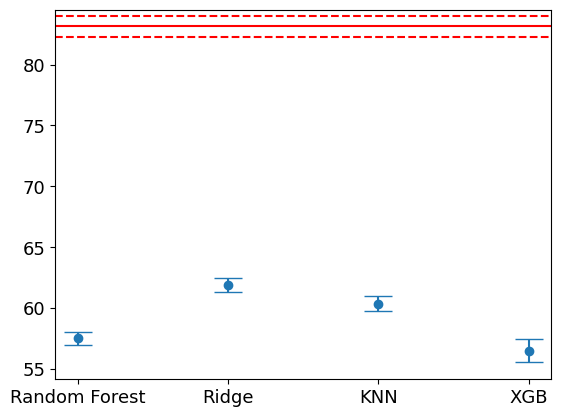

In [311]:
plt.errorbar(name,
             means,yerr=stds,
             label = "test scores", 
             fmt = "o",capsize = 10)
plt.axhline(y=BASE_mean, color='r', linestyle='-')
plt.axhline(y=BASE_mean-BASE_std, color='r', linestyle='--')
plt.axhline(y=BASE_mean+BASE_std, color='r', linestyle='--')
plt.show()

In [319]:
## STD
XGB_std

0.9785346862324206

In [321]:
## STD away
(BASE_mean-XGB_mean)/XGB_std

27.207101179372273

### Global Feature Important

#### Permutation

In [189]:
result = permutation_importance(XGBST[2][1], 
                           np.array(XGBST[3][0][1]), 
                           XGBST[3][1][1], 
                           n_repeats=10, 
                           random_state=0, 
                           scoring = 'neg_root_mean_squared_error')
scores = result.importances
scores_mean = result.importances_mean

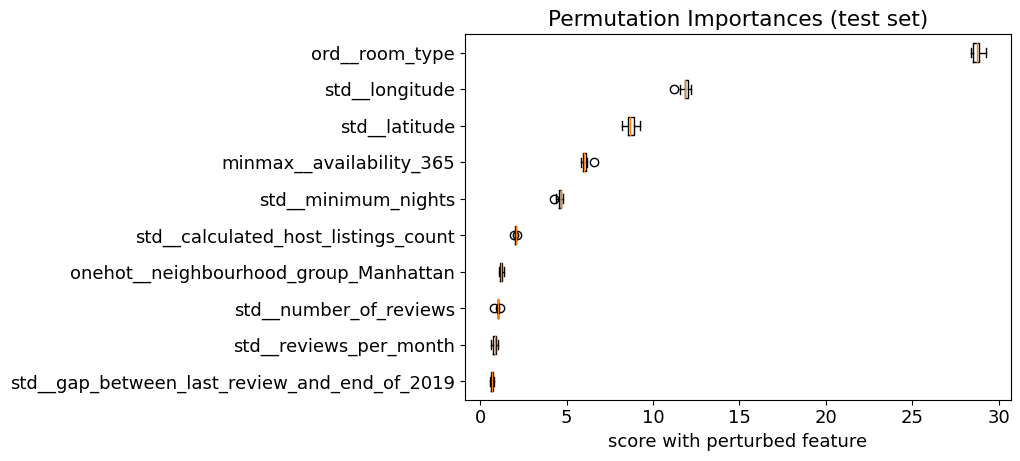

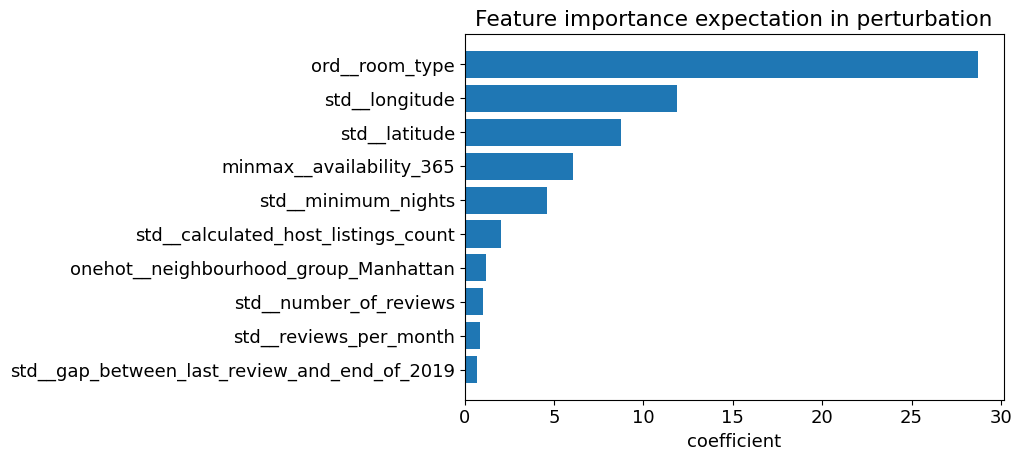

In [204]:
sorted_indcs = np.argsort(np.abs(scores_mean))[::-1]
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(10.4,4.8))
plt.boxplot(scores[sorted_indcs[:10][::-1]].T,labels=feature_names[sorted_indcs[:10][::-1]],vert=False)
#plt.axvline(0)
#plt.xscale("symlog")
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.show()
## importance score expectation
plt.figure(figsize=(10.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),scores_mean[sorted_indcs[:10][::-1]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[:10][::-1]])
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in perturbation')
plt.tight_layout()
plt.show()

#### Built-in

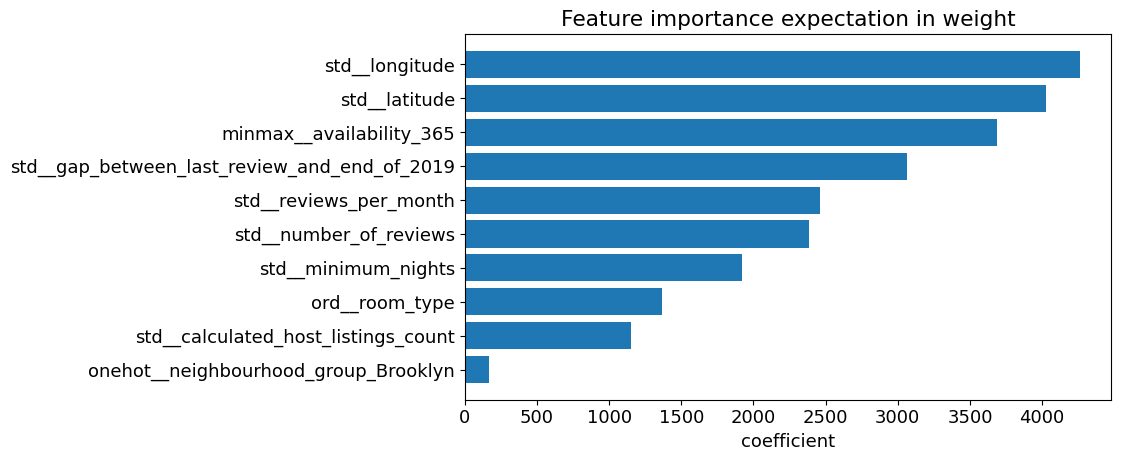

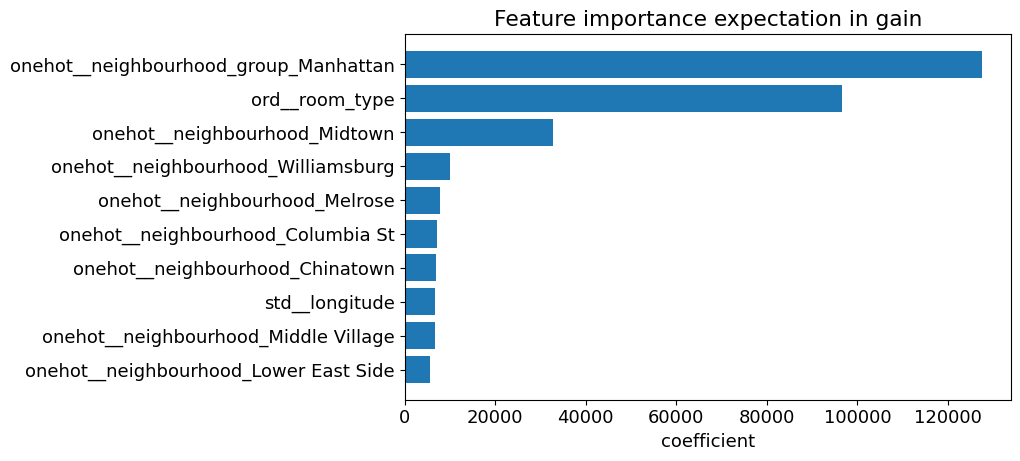

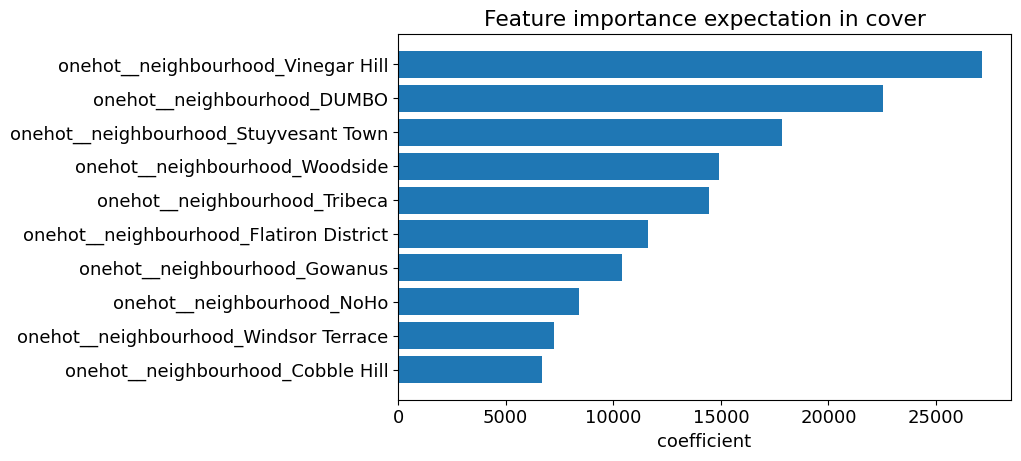

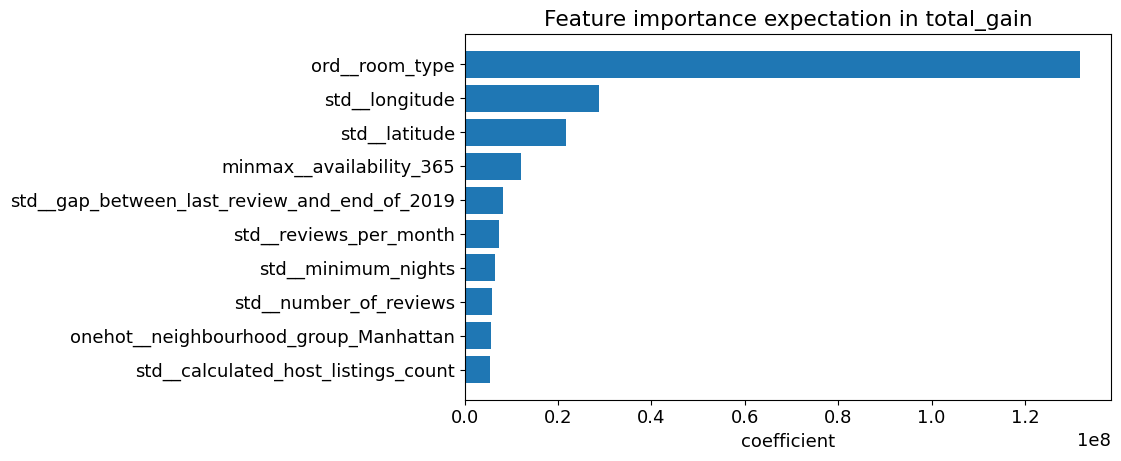

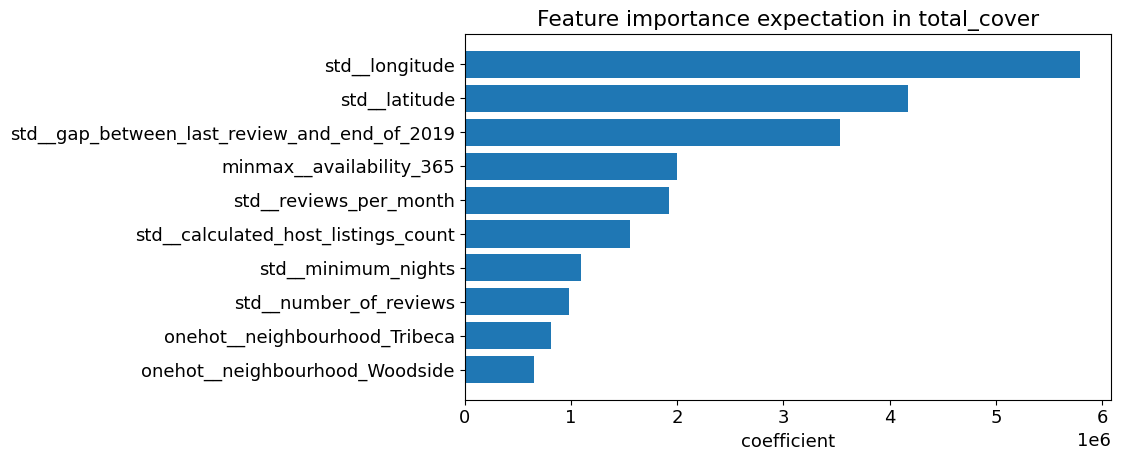

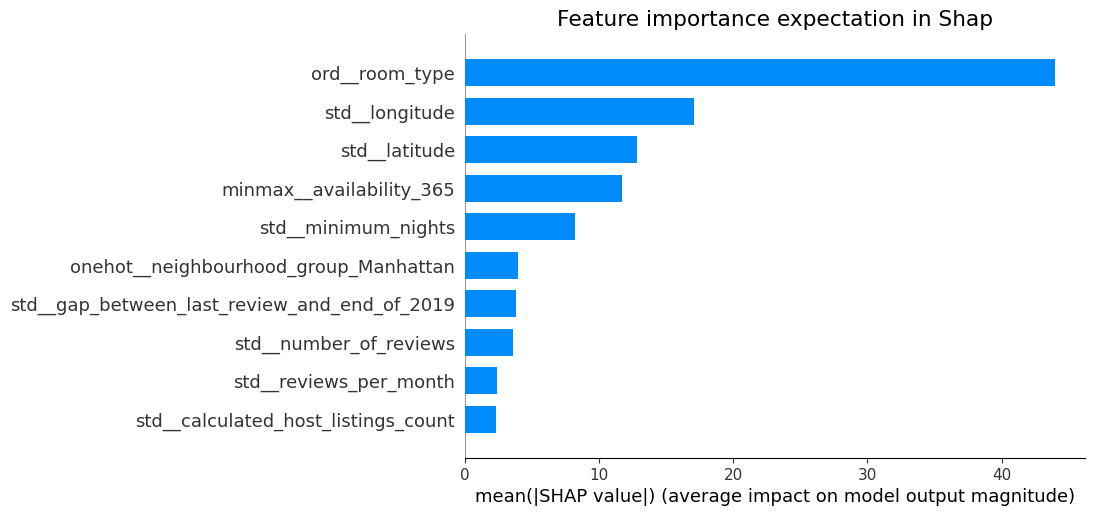

In [222]:
## gain
f = ["weight","gain","cover","total_gain","total_cover"]

###
value = XGBST[2][1].get_booster().get_score(importance_type = f[0])
sorted_indcs = np.argsort(list(value.values()))
top_10 = np.array(list(value.items()))[sorted_indcs[-10:]]
score = [float(i[1]) for i in top_10]
name  = [i[0] for i in top_10]

plt.figure(figsize=(11.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),score)
plt.yticks(np.arange(10),name)
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in weight')
plt.tight_layout()
plt.show()
###




value = XGBST[2][1].get_booster().get_score(importance_type = f[1])
sorted_indcs = np.argsort(list(value.values()))
top_10 = np.array(list(value.items()))[sorted_indcs[-10:]]
score = [float(i[1]) for i in top_10]
name  = [i[0] for i in top_10]

### 
plt.figure(figsize=(10.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),score)
plt.yticks(np.arange(10),name)
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in gain')
plt.tight_layout()
plt.show()

###
value = XGBST[2][1].get_booster().get_score(importance_type = f[2])
sorted_indcs = np.argsort(list(value.values()))
top_10 = np.array(list(value.items()))[sorted_indcs[-10:]]
score = [float(i[1]) for i in top_10]
name  = [i[0] for i in top_10]

plt.figure(figsize=(10.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),score)
plt.yticks(np.arange(10),name)
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in cover')
plt.tight_layout()
plt.show()

###
## total gain
f = ["weight","gain","cover","total_gain","total_cover"]
value = XGBST[2][1].get_booster().get_score(importance_type = f[3])
sorted_indcs = np.argsort(list(value.values()))
top_10 = np.array(list(value.items()))[sorted_indcs[-10:]]
score = [float(i[1]) for i in top_10]
name  = [i[0] for i in top_10]

plt.figure(figsize=(11.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),score)
plt.yticks(np.arange(10),name)
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in total_gain')
plt.tight_layout()
plt.show()

###
## total cover
f = ["weight","gain","cover","total_gain","total_cover"]
value = XGBST[2][1].get_booster().get_score(importance_type = f[4])
sorted_indcs = np.argsort(list(value.values()))
top_10 = np.array(list(value.items()))[sorted_indcs[-10:]]
score = [float(i[1]) for i in top_10]
name  = [i[0] for i in top_10]

plt.figure(figsize=(11.4,4.8))
plt.rcParams.update({'font.size': 13})
plt.barh(np.arange(10),score)
plt.yticks(np.arange(10),name)
#plt.xscale("symlog")
plt.xlabel('coefficient')
plt.title('Feature importance expectation in total_cover')
plt.tight_layout()
plt.show()

shap.initjs() # required for visualizations later on
explainer = shap.TreeExplainer(XGBST[2][1], verbosity = 0)
X = np.array(XGBST[3][0][1])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, 
                  X,
                  feature_names = feature_names, 
                  max_display = 10, 
                  plot_type = "bar",
                  show=False)
plt.title("Feature importance expectation in Shap")
plt.show()

### Local Feature Importance

In [224]:
shap.initjs() # required for visualizations later on
explainer = shap.TreeExplainer(XGBST[2][1], verbosity = 0)
base_value = explainer.expected_value
X = np.array(XGBST[3][0][1])
shap_values = explainer.shap_values(X)

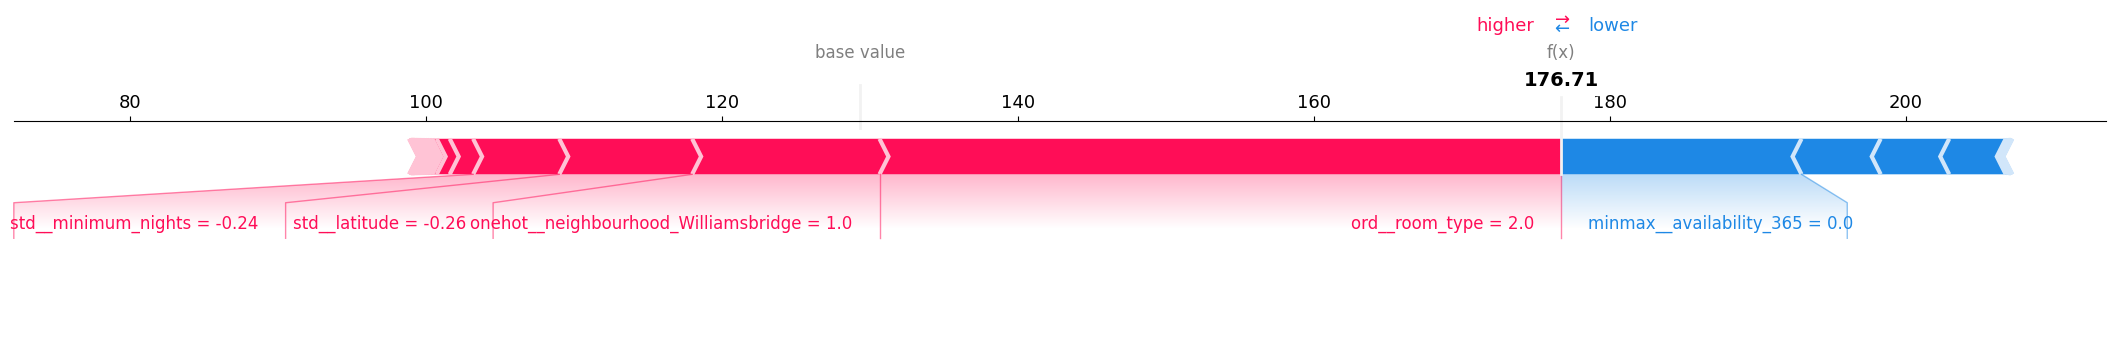

In [247]:
import matplotlib.pyplot as plt
index = 5
display(shap.force_plot(base_value, 
                np.round(shap_values[index,:],2), 
                features = np.round(X[index,:],2),
                feature_names = feature_names,
                show=False,
                matplotlib=True,figsize=(27, 3)))

[129.3733504]


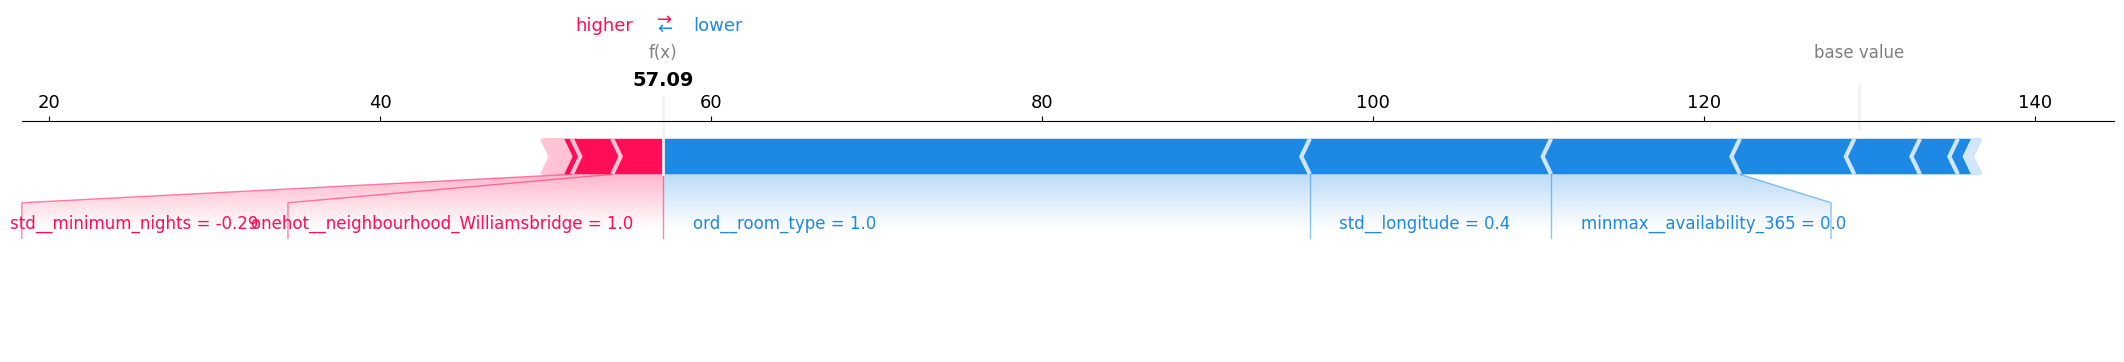

In [249]:
print(base_value)
index = 1
display(shap.force_plot(base_value, 
                np.round(shap_values[index,:],2), 
                features = np.round(X[index,:],2),
                feature_names = feature_names,
                show=False,
                matplotlib=True,figsize=(27, 3)))

### Save Model


In [329]:
knn_RMSE, knn_R2, knn_model = KNN
import pickle
file = open("KNN/KNN.save","wb")
pickle.dump((knn_RMSE, knn_R2, knn_model),file)

In [330]:
rf_RMSE, rf_R2, rf_model = RF
import pickle
file = open("Random_Forest/RF.save","wb")
pickle.dump((rf_RMSE, rf_R2, rf_model),file)

In [331]:
rg_RMSE, rg_R2, rg_model = RG
import pickle
file = open("Ridge/RG.save","wb")
pickle.dump((rg_RMSE, rg_R2, rg_model),file)

In [332]:
svm_RMSE, svm_R2, svm_model = SVM
import pickle
file = open("SVM/SVM.save","wb")
pickle.dump((svm_RMSE, svm_R2, svm_model),file)

In [339]:
test_RMSE, test_R2, final_models, test_set = XGBST
import pickle
file = open("XGB/XGB.save","wb")
pickle.dump((test_RMSE, test_R2, final_models, test_set),file)